In [1]:
import pandas as pd
import numpy as np

In [4]:
# https://www.kaggle.com/datasets/binaryjoker/airline-passenger-satisfaction
df = pd.read_csv("../lab1/airline_passenger_satisfaction.csv", index_col=0)
df.head()

,Gender,customer_type,age,type_of_travel,customer_class,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,...,inflight_entertainment,onboard_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [5]:
df = df.dropna()
df["satisfaction"] = df["satisfaction"].map({"neutral or dissatisfied":0, "satisfied":1})

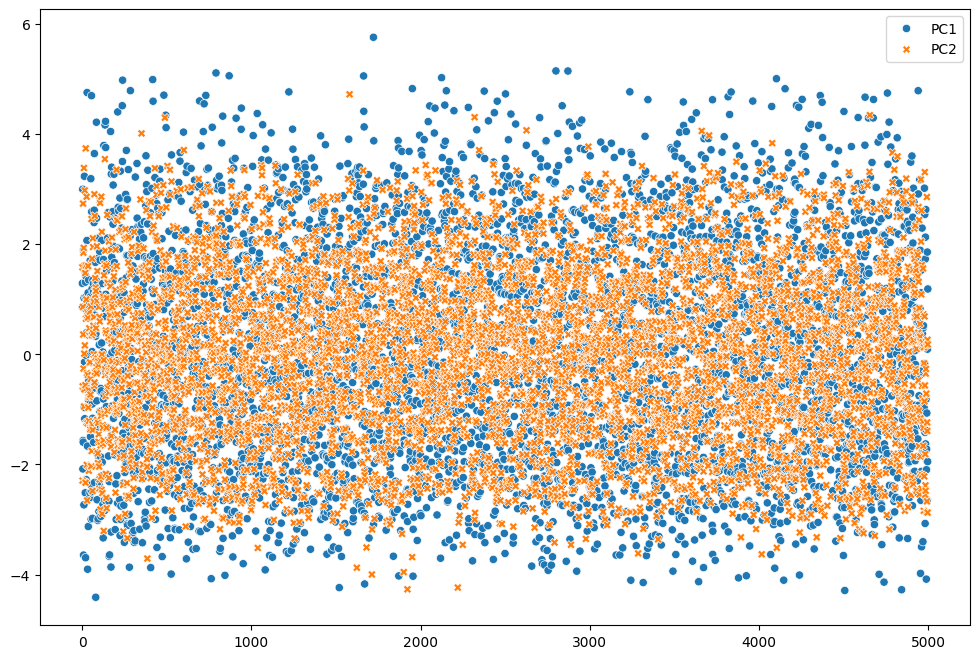

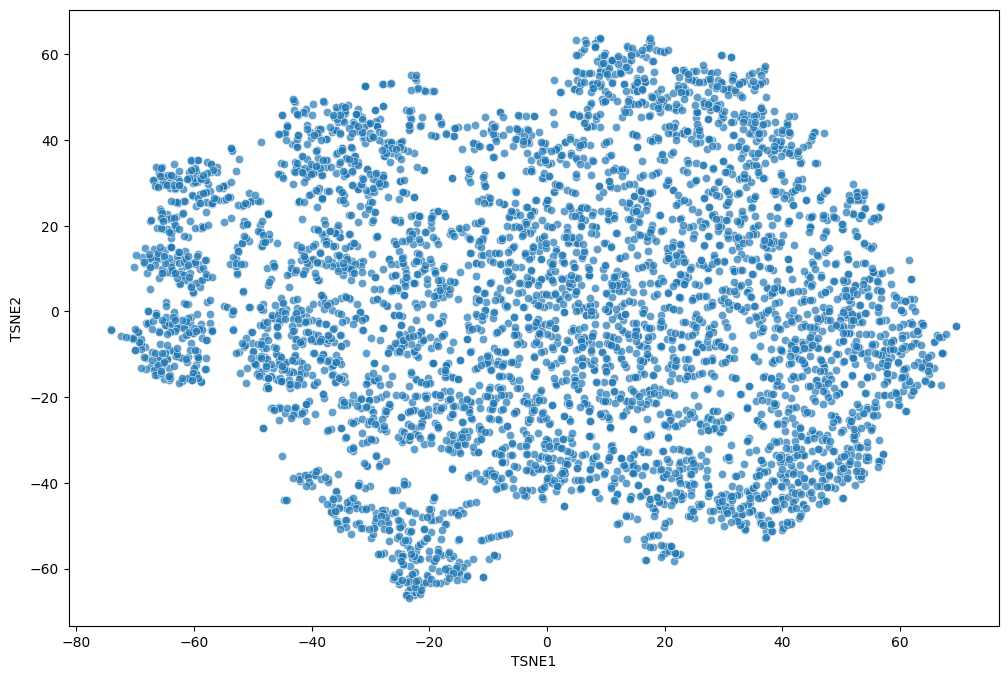

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def apply_pca_95_variance(data, target_column, output_file):
    # Separate the target column from the dataset
    features_data = data.drop(columns=[target_column]).sample(n=5000)

    # Keep only numeric columns in the feature data
    numeric_data = features_data.select_dtypes(include=[float, int])

    # Standardize the numeric data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(numeric_data)

    # Apply PCA
    pca = PCA()
    pca.fit(scaled_data)
    # Apply PCA with the selected number of components
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(scaled_data)
    # Create a DataFrame for the reduced data, with component names (PC1, PC2, etc.)
    pc_columns = [f"PC{i+1}" for i in range(2)]
    reduced_df = pd.DataFrame(reduced_data, columns=pc_columns)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(reduced_df)
    plt.show()
    # Apply t-SNE with 2 components (for visualization)
    tsne = TSNE(n_components=2)
    tsne_data = tsne.fit_transform(scaled_data)

    # Create a DataFrame for the t-SNE data, with component names (TSNE1, TSNE2)
    tsne_columns = [f"TSNE{i+1}" for i in range(2)]
    tsne_df = pd.DataFrame(tsne_data, columns=tsne_columns)

    # Plot the t-SNE result
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", alpha=0.7)
    plt.show()


apply_pca_95_variance(df, "satisfaction", "pca_data.csv")

/home/strongich/miniconda3/envs/main/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/strongich/miniconda3/envs/main/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/strongich/miniconda3/envs/main/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/strongich/miniconda3/envs/main/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureW

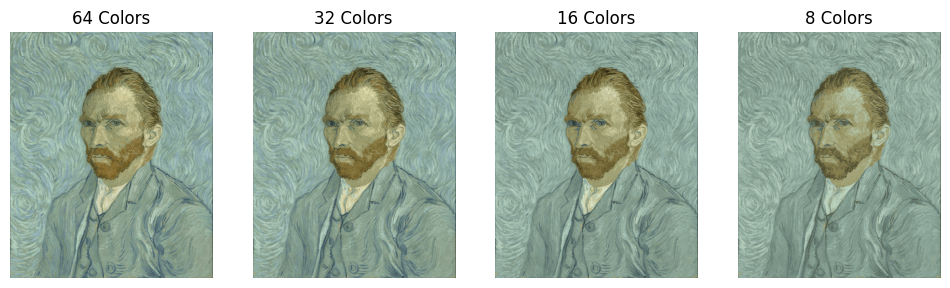

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from PIL import Image


def quantize_image(image_path, n_colors):
    # Відкрити зображення
    image = Image.open(image_path)
    image = image.convert("RGB")  # Перетворення зображення у формат RGB
    image_np = (
        np.array(image, dtype=np.float64) / 255
    )  # Масштабування значень до [0, 1]

    # Отримати форму зображення (ширина, висота, кількість каналів)
    w, h, d = image_np.shape
    image_array = np.reshape(image_np, (w * h, d))

    # Вибираємо випадкові пікселі для тренування k-means (для пришвидшення)
    image_array_sample = shuffle(image_array, random_state=0)[:1000]

    # Створюємо і навчаємо модель k-means
    kmeans = KMeans(n_clusters=n_colors, random_state=42).fit(image_array_sample)

    # Прогнозуємо значення кластерів для всіх пікселів
    labels = kmeans.predict(image_array)

    # Заміна кожного пікселя відповідним кольором центроїда
    new_image_array = kmeans.cluster_centers_[labels]
    new_image = np.reshape(new_image_array, (w, h, d))

    # Повернення результату
    return new_image


def plot_quantized_images(image_path, levels):
    plt.figure(figsize=(12, 8))

    for i, n_colors in enumerate(levels):
        # Квантуємо зображення
        quantized_image = quantize_image(image_path, n_colors)

        # Відображаємо результати
        plt.subplot(1, len(levels), i + 1)
        plt.imshow(quantized_image)
        plt.title(f"{n_colors} Colors")
        plt.axis("off")

    plt.show()


# Виклик функції для відображення результатів з різними рівнями
image_path = "van.jpg"  # Вкажіть шлях до зображення
plot_quantized_images(image_path, [64, 32, 16, 8])

In [3]:
import json
import pandas as pd

data = []
with open("yelp_academic_dataset_review.json", "r") as file:
    for line in file:
        try:
            # Зчитуємо JSON-рядок
            review = json.loads(line)
            # Додаємо тільки потрібні поля "stars" і "text"
            data.append({
                "stars": review["stars"],
                "text": review["text"]
            })
        except json.JSONDecodeError as e:
            print(f"Помилка при обробці рядка: {e}")
        except KeyError as e:
            print(f"Відсутнє поле: {e}")

# Створюємо DataFrame з отриманих даних
df = pd.DataFrame(data)

In [7]:
print(df.shape)
df.head()
df = df.sample(n=50000)

(6990280, 2)


In [8]:
df['class'] = df['stars'].apply(lambda x: 1 if x >= 3 else 0)

In [15]:
df.head()
df.to_csv("nltdata.csv")

In [8]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd
# Завантажуємо необхідні ресурси NLTK
nltk.download('stopwords')
nltk.download('punkt_tab')
data = pd.read_csv("nltdata.csv", index_col=0)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/strongich/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/strongich/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [6]:
data.head()

,stars,text,class
2425793,5.0,Heading back to DC from a wedding on Cape May ...,1
4665728,1.0,"What is there: art installations, art pieces, ...",0
6485339,5.0,Best beach in the burg. Park down by the grill...,1
3737105,1.0,Ordered an arrangement to be delivered as a th...,0
3993257,5.0,We ordered a burrito and the quesabarrias! WOW...,1


In [9]:
stop_words = set(stopwords.words("english"))


def preprocess_text(text):
    # Перетворюємо до нижнього регістру
    text = text.lower()
    # Видаляємо пунктуацію
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Токенізуємо текст
    words = word_tokenize(text)
    # Видаляємо стоп-слова
    words = [word for word in words if word not in stop_words]
    return " ".join(words)


data["cleaned_text"] = data["text"].apply(preprocess_text)

In [10]:
data.head()

,stars,text,class,cleaned_text
2425793,5.0,Heading back to DC from a wedding on Cape May ...,1,heading back dc wedding cape may saw place tho...
4665728,1.0,"What is there: art installations, art pieces, ...",0,art installations art pieces architecture inte...
6485339,5.0,Best beach in the burg. Park down by the grill...,1,best beach burg park grill great water casual ...
3737105,1.0,Ordered an arrangement to be delivered as a th...,0,ordered arrangement delivered thank gift order...
3993257,5.0,We ordered a burrito and the quesabarrias! WOW...,1,ordered burrito quesabarrias wow amazing steak...


In [14]:
data = data.drop("index", axis=1)
data.head()

,stars,text,class,cleaned_text
0,5.0,Heading back to DC from a wedding on Cape May ...,1,heading back dc wedding cape may saw place tho...
1,1.0,"What is there: art installations, art pieces, ...",0,art installations art pieces architecture inte...
2,5.0,Best beach in the burg. Park down by the grill...,1,best beach burg park grill great water casual ...
3,1.0,Ordered an arrangement to be delivered as a th...,0,ordered arrangement delivered thank gift order...
4,5.0,We ordered a burrito and the quesabarrias! WOW...,1,ordered burrito quesabarrias wow amazing steak...


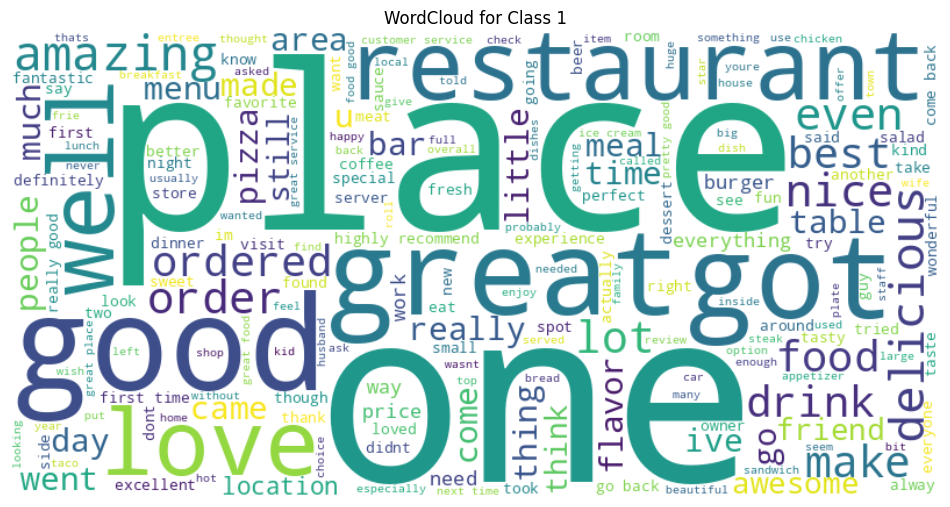

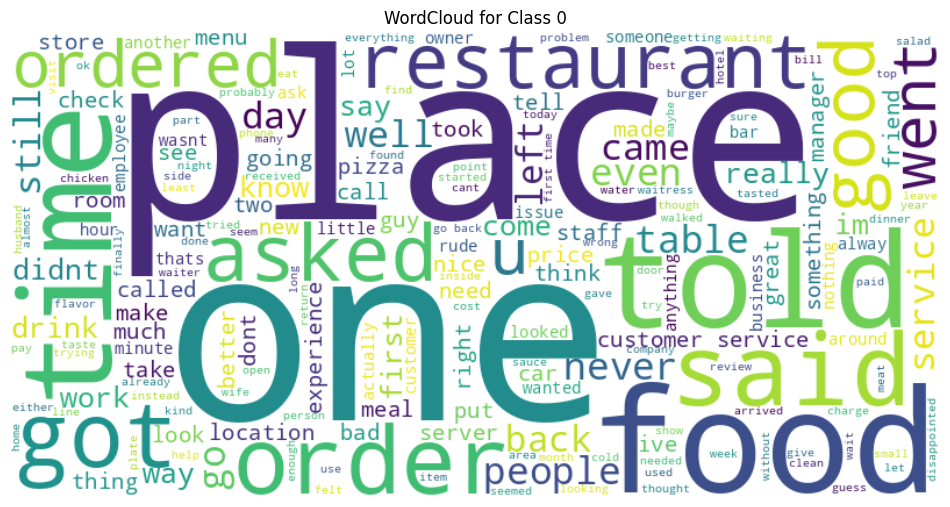

In [16]:
import matplotlib.pyplot as plt
def generate_wordcloud(text_data, class_label):
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
        " ".join(text_data)
    )
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"WordCloud for Class {class_label}")
    plt.axis("off")
    plt.show()


# Візуалізуємо найбільш поширені слова для кожного класу
for class_label in data["class"].unique():
    class_data = data[data["class"] == class_label]["cleaned_text"]
    generate_wordcloud(class_data, class_label)

In [17]:
# Векторизація тексту за допомогою TfidfVectorizer
tfidf = TfidfVectorizer(
    max_features=1000
)  # max_features обмежує кількість унікальних слів
X = tfidf.fit_transform(data["cleaned_text"]).toarray()

# Перетворення класів у числові значення (якщо потрібно)
y = data["class"].values

# Поділ на навчальну та тестову вибірку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [22]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

model = MultinomialNB()
model.fit(X_train, y_train)

# Прогнозуємо на тестовій вибірці
y_pred = model.predict(X_test)

# Оцінка точності
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Друкуємо детальний звіт про класифікацію
report = classification_report(y_test, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.57      0.69      2290
           1       0.88      0.97      0.93      7710

    accuracy                           0.88     10000
   macro avg       0.87      0.77      0.81     10000
weighted avg       0.88      0.88      0.87     10000

